In [110]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

import fuzzywuzzy
from fuzzywuzzy import process
import chardet

earthquakes = pd.concat([pd.read_csv("datasets/earthquake2019/"+ month +" 2019.csv") for month in ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']])
earthquakes.dropna(inplace=True)

In [111]:
earthquakes = pd.DataFrame(earthquakes.rename(columns={'Date - Time\n(Philippine Time)':'Datetime',
                                                       'Latitude\n(ºN)':'Latitude',
                                                       'Longitude\n(ºE)':'Longitude',
                                                       'Depth\n(km)':'Depth'}))
earthquakes.Datetime = pd.to_datetime(earthquakes.Datetime, format="%d %B %Y - %I:%M %p")
earthquakes.head()

,Datetime,Latitude,Longitude,Depth,Mag,Location
0,2019-01-31 14:55:00,9.64,122.21,6,2.7,025 km S 58° W of Sipalay (Negros Occidental)
1,2019-01-31 12:13:00,8.44,126.61,24,3.7,031 km N 76° E of Hinatuan (Surigao Del Sur)
2,2019-01-31 11:38:00,9.81,126.44,7,2.9,032 km N 85° E of General Luna (Surigao Del No...
3,2019-01-31 09:05:00,5.45,126.06,53,2.2,066 km N 88° E of Sarangani (Davao Occidental)
4,2019-01-31 07:14:00,5.85,126.16,15,2.7,060 km S 87° E of Jose Abad Santos (Davao Occi...


<AxesSubplot:xlabel='Mag', ylabel='Count'>

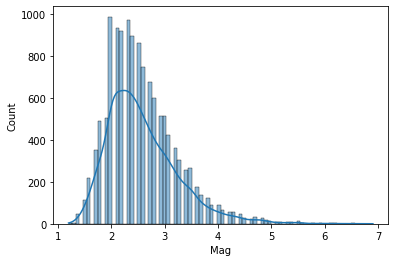

In [3]:
sns.histplot(earthquakes.Mag, kde=True)

<AxesSubplot:xlabel='Datetime', ylabel='Mag'>

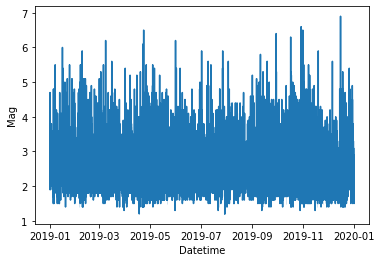

In [4]:
sns.lineplot(x=earthquakes.Datetime, y=earthquakes.Mag)

In [5]:
day_of_month_earthquake = earthquakes.Datetime.dt.day

In [6]:
day_of_month_earthquake.head()

0    31
1    31
2    31
3    31
4    31
Name: Datetime, dtype: int64

In [7]:
day_of_month_earthquake.dropna(inplace=True)

<AxesSubplot:xlabel='Datetime', ylabel='Count'>

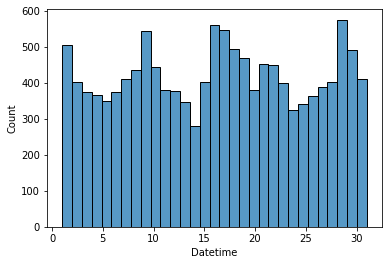

In [8]:
sns.histplot(day_of_month_earthquake, kde=False, bins=31)

In [9]:
month_of_earthquakes = earthquakes.Datetime.dt.month

In [10]:
month_of_earthquakes.head()

0    1
1    1
2    1
3    1
4    1
Name: Datetime, dtype: int64

In [11]:
month_of_earthquakes.dropna(inplace=True)

<AxesSubplot:xlabel='Datetime', ylabel='Count'>

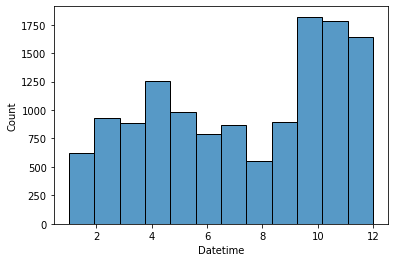

In [12]:
sns.histplot(month_of_earthquakes, kde=False, bins=12)

In [13]:
print(len(earthquakes))

13028


In [14]:
october_earthquake = earthquakes.loc[earthquakes.Datetime.dt.month == 10].Datetime.dt.day

<AxesSubplot:xlabel='Datetime', ylabel='Count'>

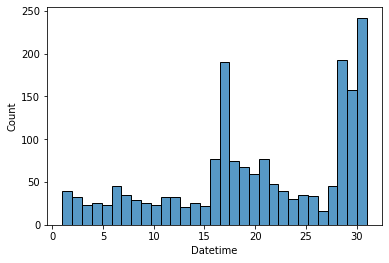

In [15]:
sns.histplot(october_earthquake, kde=False, bins=31)

### Magnitude for October 2019

<AxesSubplot:xlabel='Datetime', ylabel='Mag'>

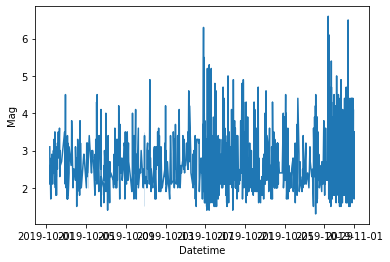

In [22]:
october_earthquakes = earthquakes.loc[earthquakes.Datetime.dt.month == 10]
sns.lineplot(data=october_earthquakes, x=october_earthquakes.Datetime, y=october_earthquakes.Mag)

In [112]:
earthquakes['Month'] = earthquakes.Datetime.dt.month
earthquakes['Day'] = earthquakes.Datetime.dt.day

In [69]:
earthquakes

,Datetime,Latitude,Longitude,Depth,Mag,Location,Month,Day
0,2019-01-31 14:55:00,9.64,122.21,6,2.7,025 km S 58° W of Sipalay (Negros Occidental),1,31
1,2019-01-31 12:13:00,8.44,126.61,24,3.7,031 km N 76° E of Hinatuan (Surigao Del Sur),1,31
2,2019-01-31 11:38:00,9.81,126.44,7,2.9,032 km N 85° E of General Luna (Surigao Del No...,1,31
3,2019-01-31 09:05:00,5.45,126.06,53,2.2,066 km N 88° E of Sarangani (Davao Occidental),1,31
4,2019-01-31 07:14:00,5.85,126.16,15,2.7,060 km S 87° E of Jose Abad Santos (Davao Occi...,1,31
...,...,...,...,...,...,...,...,...
1640,2019-12-01 03:16:00,7.69,124.84,16,2.7,017 km S 10° E of Pangantucan (Bukidnon),12,1
1641,2019-12-01 03:02:00,5.96,125.53,38,2.9,101 km N 85° E of Jose Abad Santos (Davao Occi...,12,1
1642,2019-12-01 02:49:00,14.04,119.71,1,2.0,048 km N 66° W of Lubang (Occidental Mindoro),12,1
1643,2019-12-01 02:19:00,6.94,124.95,24,1.7,018 km S 63° W of Kidapawan City (Cotabato),12,1


In [79]:
def replace_matches_in_column(df, column, string_to_match, min_ratio=500):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, limit=3, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    
    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    
    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)
    
    # replace all rows with close matches with the input matches
    df.loc[rows_with_matches, column] = string_to_match
    
    print(string_to_match)

In [126]:
format_indeces = earthquakes.Location.loc[(earthquakes.Location.str.contains('W')) & (earthquakes.Location.str.contains('E'))].index

In [142]:
formatted_location = earthquakes.iloc[format_indeces].Location.str[17:]

In [144]:
non_formatted.Location

0           025 km S 58° W of Sipalay (Negros Occidental)
1            031 km N 76° E of Hinatuan (Surigao Del Sur)
2       032 km N 85° E of General Luna (Surigao Del No...
3          066 km N 88° E of Sarangani (Davao Occidental)
4       060 km S 87° E of Jose Abad Santos (Davao Occi...
5               046 km N 65° E of Hernani (Eastern Samar)
6                  044 km N 10° E of Pandan (Catanduanes)
7           026 km N 19° E of Hinundayan (Southern Leyte)
8           004 km S 22° W of Hinunangan (Southern Leyte)
9       009 km S 836° E of General Luna (Surigao Del N...
10                    047 km S 62° E of Gonzaga (Cagayan)
11               006 km S 80° W of San Antonio (Zambales)
12      024 km S 13° E of Governor Generoso (Davao Ori...
13                   022 km S 87° W of Nasugbu (Batangas)
14                      011 km N 81S° E of Abuyog (Leyte)
15      056 km S 57° E of Don Marcelino (Davao Occiden...
16      025 km S 81° E of General Luna (Surigao Del No...
17          01

In [81]:
for province in earthquakes.Province.unique():
    replace_matches_in_column(earthquakes, 'Province', province)

 Sipalay (Negros Occidental)
 Hinatuan (Surigao Del Sur)
 General Luna (Surigao Del Norte)
 Sarangani (Davao Occidental)
 Jose Abad Santos (Davao Occidental)
 Hernani (Eastern Samar)
 Pandan (Catanduanes)
 Hinundayan (Southern Leyte)
 Hinunangan (Southern Leyte)
f General Luna (Surigao Del Norte)
 Gonzaga (Cagayan)
 San Antonio (Zambales)
 Governor Generoso (Davao Oriental)
 Nasugbu (Batangas)
f Abuyog (Leyte)
 Don Marcelino (Davao Occidental)
 San Pascual (Masbate)
 Cortes (Surigao Del Sur)
 Iba (Zambales)
 Valencia City (Bukidnon)
 Balanga City (Bataan)
 Caluya (Antique)
 Concepcion (Tarlac)
 Divilacan (Isabela)
 Malita (Davao Occidental)
 Calayan (Cagayan)
 Balangkayan (Eastern Samar)
 Libjo (Surigao Del Norte)
 Mondragon (Northern Samar)
 Currimao (Ilocos Norte)
 San Vicente (Northern Samar)
 Mabinay (Negros Oriental)
 Javier (Bugho) (Leyte)
 Bacnotan (La Union)
 Sabtang (Batanes)
 Madrid (Surigao Del Sur)
 Basay (Negros Oriental)
 Masinloc (Zambales)
 Hinoba-an (Negros Occidental)

In [83]:
earthquakes.Province.unique()

array([' Sipalay (Negros Occidental)', ' Hinatuan (Surigao Del Sur)',
       ' General Luna (Surigao Del Norte)',
       ' Sarangani (Davao Occidental)',
       ' Jose Abad Santos (Davao Occidental)', ' Hernani (Eastern Samar)',
       ' Pandan (Catanduanes)', ' Hinundayan (Southern Leyte)',
       ' Hinunangan (Southern Leyte)',
       'f General Luna (Surigao Del Norte)', ' Gonzaga (Cagayan)',
       ' San Antonio (Zambales)', ' Governor Generoso (Davao Oriental)',
       ' Nasugbu (Batangas)', 'f Abuyog (Leyte)',
       ' Don Marcelino (Davao Occidental)', ' San Pascual (Masbate)',
       ' Cortes (Surigao Del Sur)', ' Iba (Zambales)',
       ' Valencia City (Bukidnon)', ' Balanga City (Bataan)',
       ' Caluya (Antique)', ' Concepcion (Tarlac)',
       ' Divilacan (Isabela)', ' Malita (Davao Occidental)',
       ' Calayan (Cagayan)', ' Balangkayan (Eastern Samar)',
       ' Libjo (Surigao Del Norte)', ' Mondragon (Northern Samar)',
       ' Currimao (Ilocos Norte)', ' San Vicente 